# Inspect

## imports

In [1]:
import sys
import numpy as np
import pandas as pd
import pickle
import os

#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # or any {'0', '1', '2'}

import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv1D,
    ZeroPadding2D,
    Activation,
    Input,
    concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAvgPool1D, MaxPooling1D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense, ReLU
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
from tensorflow.keras import activations
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
import numpy.random as rng
from common_funcs_2 import pad_seqs_to_onehot
import common_funcs_2 as cf
import model_def
import json

## M

In [14]:
with open("config.json", "r") as f:
    p = json.load(f)

In [4]:
SCRATCH_PATH = p["SCRATCH_PATH"]
DATA_PATH = SCRATCH_PATH + "/ML/struct/"
SAVE_PLOTS_DIR = SCRATCH_PATH + "/ML/struct/save/plots/"
SAVE_WEIGHTS_DIR = SCRATCH_PATH + "/ML/struct/save/weights/"
CHECKPOINT_DIR = SCRATCH_PATH + "/ML/struct/save/chkpt/"

In [10]:
df_scores_all = pd.read_pickle(DATA_PATH + "SCORES.pkl.gz")

In [17]:
FILTERING = True
max_tm_scores = np.maximum(df_scores_all["TM1"], df_scores_all["TM2"])
df_scores_all["distance"] = 1 - max_tm_scores
df_scores_all["weight"] = (max_tm_scores/df_scores_all["pidentity"])**p["WEIGHT_EXPONENT"]
max_seq_len = p["MAX_SEQ_LEN"]
print("Discarding pairs >{} residues, and TMscore>{:.2f}".format(max_seq_len, p["TMSCORE_CUTOFF"]))
if (p["WEIGHTED_SAMPLES"]):
    print("Weighting the samples. Exponent =",p["WEIGHT_EXPONENT"])
    
# Select the training set.
length_filter = (df_scores_all.qlen <= max_seq_len) & (
    df_scores_all.tlen <= max_seq_len
)
tm_score_filter = df_scores_all.distance > (1 - p["TMSCORE_CUTOFF"])

train_filter = length_filter & tm_score_filter & (df_scores_all.train_or_holdout == 0)
double_HO_filter = length_filter & tm_score_filter & (df_scores_all.train_or_holdout == 3)

df_train_and_val = df_scores_all[train_filter]
df_double_holdout = df_scores_all[double_HO_filter]

print("Training set size:", len(df_train_and_val))
print("Validation set size (double-holdouts):", len(df_double_holdout))

Discarding pairs >400 residues, and TMscore>0.90
Weighting the samples. Exponent = 3
Training set size: 1230504
Validation set size (double-holdouts): 42881


In [4]:
"""
   Read the training df
"""

# FILTERING = True
# max_tm_scores = np.maximum(df_scores_all["TM1"], df_scores_all["TM2"])
# df_scores_all["distance"] = 1 - max_tm_scores
# max_seq_len = p["MAX_SEQ_LEN"]
# padded_len = max_seq_len + 10
# print("Discarding pairs >{} residues.".format(max_seq_len))

# # Select the training set.
# length_filter = (df_scores_all.qlen <= max_seq_len) & (
#     df_scores_all.tlen <= max_seq_len
# )
# tm_score_filter = df_scores_all.distance < (1 - p["TMSCORE_CUTOFF"])

# train_filter = length_filter & (df_scores_all.train_or_holdout == 0)
# double_HO_filter = length_filter & (df_scores_all.train_or_holdout == 3)

# df_train_and_val = df_scores_all[train_filter]
# df_double_holdout = df_scores_all[double_HO_filter]

# print("Training set size:", len(df_train_and_val))
# print("Validation set size (double-holdouts):", len(df_double_holdout))

Discarding pairs >400 residues.
Training set size: 2288424
Validation set size (double-holdouts): 65714


In [18]:
time_stamp = "2020_11_05__20h45m"
model = model_def.get_siamese_model(padded_len)
optimizer = Adam(lr=0.0005)
model.compile(loss="MSE", optimizer=optimizer)

checkpoint_path = CHECKPOINT_DIR + time_stamp + ".ckpt"
model.load_weights(checkpoint_path)
print("Loaded checkpoint...")

(410, 20)
Loaded checkpoint...


In [22]:
HOLDOUT_SAMPLE_SIZE = 5000
WHICH_SET="DOUBLE-HOLDOUT SET"
df_sample = df_double_holdout.sample(n=HOLDOUT_SAMPLE_SIZE)
q_seqs = df_sample.qseq.values.tolist()
t_seqs = df_sample.tseq.values.tolist()
tmalign_distance = df_sample.distance

In [24]:
"""
    Converting sequences to one-hot representations
"""
print("Conveting to one-hot...")
q_seqs_ohe = pad_seqs_to_onehot(
    q_seqs, padded_len, max_seq_len, random_padding=False, center_padding=True
)

t_seqs_ohe = pad_seqs_to_onehot(
    t_seqs, padded_len, max_seq_len, random_padding=False, center_padding=True
)


# float16 greatly reduces df saving time.
print("Generating representations")
start = time.time()
predicted_distance = np.array(model.predict([q_seqs_ohe, t_seqs_ohe]).flatten())

Conveting to one-hot...
Generating representations


Plotting...


Text(0, 0.5, 'Predicted Distance')

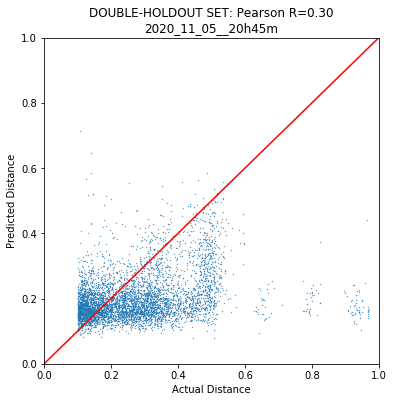

In [25]:
import scipy 
q_len = np.array([len(x) for x in q_seqs])
t_len = np.array([len(x) for x in t_seqs])
len_ratio = (q_len - t_len) / q_len
distance_ratio = tmalign_distance / predicted_distance

print("Plotting...")
R, pval = scipy.stats.pearsonr(tmalign_distance, predicted_distance)
title = "{}: Pearson R={:.2f}\n{}".format(WHICH_SET, R, time_stamp)

fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor("white")
plt.axis((0.0, 1, 0.0, 1))
plt.scatter(tmalign_distance, predicted_distance, s=0.1)
plt.plot([0, 1], [0, 1], color="red")
plt.title(title)
plt.xlabel("Actual Distance")
plt.ylabel("Predicted Distance")

In [29]:
df_scores_all[['qid', 'tid', 'TM1',
       'TM2', 'pidentity', 'weight']].sample(20).sort_values(by='pidentity')

qid     tid     TM1     TM2  pidentity        weight
1418433  2wuz_A  6cr2_A  0.9072  0.8612     30.061  2.748520e-05
692928   1oky_A  6gvx_A  0.8416  0.7547     30.370  2.128055e-05
912308   1wzm_A  4aee_A  0.8571  0.7392     31.203  2.072552e-05
2537253  4pjc_F  5d1x_D  0.6159  0.7211     31.651  1.182563e-05
1311463  2pzy_A  3qbn_A  0.6616  0.7578     31.944  1.335045e-05
2251657  4gg6_F  6dc3_L  0.7429  0.8354     33.636  1.532041e-05
1072281  2cfc_A  4ibo_A  0.9304  0.9164     33.730  2.098747e-05
2359106  4ju0_A  6n5a_A  0.8552  0.8724     34.862  1.567076e-05
2271346  4hbc_H  6u1t_H  0.7695  0.7378     56.542  2.520649e-06
2783494  5d9q_D  6ws6_B  0.4253  0.4399     67.925  2.716270e-07
2799119  5drx_L  5sx4_I  0.7485  0.7713     75.909  1.049035e-06
161448   1c5b_L  5d1z_C  0.7357  0.7527     77.570  9.136595e-07
470993   1it9_H  5t3x_D  0.8302  0.7987     77.679  1.220780e-06
745920   1qbl_L  5h2b_B  0.6694  0.6766     78.972  6.288927e-07
743363   1q9k_B  4onf_H  0.7926  0.8248     79.279  1.126086e-06
2764815  5cjx_C  5dr5_L  0.7028  0.7003     82.243  6.240199e-07
37479    1a2g_A  3e2n_A  0.9635  0.9941     94.158  1.176843e-06
2090690  4oh9_A  3wws_A  0.8026  0.8566     96.078  7.086999e-07
1049915  2bim_A  6sl6_A  0.9918  0.9484     96.330  1.091409e-06
2137787  4bm7_A  5u66_A  0.9092  0.9092     99.517  7.625818e-07